# ECE 498 DS Mini Project 2

## Akhilesh Somani - somani4,
## Gowtham Kuntumalla - gowtham4,
## Manan Mehta - mananm2

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering as ac
%matplotlib inline

In [2]:
he0_df_org=pd.read_csv("RelativeAbundance_HE0.csv")
he1_df_org=pd.read_csv("RelativeAbundance_HE1.csv")

### 1. In the context of statistical analysis, why do biologists need multiple samples to identify microbes with significantly altered abundance?

Biologists need multiple samples to be sure that the data is statistically significant. Hypothesis needs to be backed by data. This helps them to conclude, with a greater confidence, which microbes are present in more numbers than usual.

### 2. How many samples were analyzed?
Number of samples analyzed were: 764

In [3]:
len(he0_df_org.set_index("Microbe Name").columns)

764

### 3. How many microbes were identified?
Number of different micorbes idenified were: 149

In [4]:
he0_df_org.groupby("Microbe Name").count().sum()[0]

149

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization
T = storage temp,
M = collection method,
C = contamination,
L = Lab time,
Q = quality

$$ P(joint) = P(Q,C,L,M,T) = P(Q|C,L,M,T) * P(C|M,T,L) * P(M|T,L) * P(T|L) * P(L)$$ 
$$ P(Q,C,L,M,T) = P(Q|C,L) * P(C|M,T) * P(M) * P(T) * P(L)$$

### b. Parameters Required
Number of values taken by:
C=2,
L=2,
T=2,
M=2,
Q=2

Parameters needed are: (2x2)+(2x2)+1+1+1 = 11

### c. Constructing Probability Tables

In [5]:
qc_df=pd.read_csv("QualityControl.csv")

In [6]:
#P(T),P(M),P(T)
feature=["strtmp","coll","labtime"]
sub_features=[["cold","cool"],["nurse","patient"],["short","long"]]
for i in range(3):
    z=qc_df.groupby(feature[i]).count()
    z.loc[sub_features[i][0]], z.loc[sub_features[i][1]] = z.loc[sub_features[i][0]]/z.sum(), z.loc[sub_features[i][1]]/z.sum()
    print(z.loc[:,'qual'])
    print("\n")

strtmp
cold    0.8982
cool    0.1018
Name: qual, dtype: float64


coll
nurse      0.8976
patient    0.1024
Name: qual, dtype: float64


labtime
long     0.2044
short    0.7956
Name: qual, dtype: float64




In [7]:
#P(Q|C,L)
z=qc_df.groupby(["cont","labtime","qual"]).count()
temp=qc_df.groupby(["cont","labtime"]).count()
for i in ['high','low']:
    for j in ['long','short']:
        for k in ['bad','good']:
            z.loc[i,j,k]=z.loc[i,j,k]/temp.loc[i,j]
        
print(z.loc[:,'strtmp'])

cont  labtime  qual
high  long     bad     0.966102
               good    0.033898
      short    bad     0.064257
               good    0.935743
low   long     bad     0.080997
               good    0.919003
      short    bad     0.042907
               good    0.957093
Name: strtmp, dtype: float64


In [8]:
#P(C|M,T)
z=qc_df.groupby(["coll","strtmp","cont"]).count()
temp=qc_df.groupby(["coll","strtmp"]).count()
for i in ['nurse','patient']:
    for j in ['cold','cool']:
        for k in ['high','low']:
            z.loc[i,j,k]=z.loc[i,j,k]/temp.loc[i,j]
        
print(z.loc[:,'qual'])

coll     strtmp  cont
nurse    cold    high    0.043983
                 low     0.956017
         cool    high    0.088435
                 low     0.911565
patient  cold    high    0.076577
                 low     0.923423
         cool    high    0.838235
                 low     0.161765
Name: qual, dtype: float64


### d. Final Probability Tables: Calculate P(Quality|Storage Temp, Collection Method, Lab Time)

In [9]:
#P(Q|T,M,L)

cpd=qc_df.groupby(["strtmp","coll","labtime","qual"]).count()
temp=qc_df.groupby(["strtmp","coll","labtime"]).count()

for i in ['cold','cool']:
    for j in ['nurse','patient']:
        for k in ['long','short']:
            for l in ['bad','good']:
                cpd.loc[i,j,k,l]=cpd.loc[i,j,k,l]/temp.loc[i,j,k]
        
print(cpd)

                                 cont
strtmp coll    labtime qual          
cold   nurse   long    bad   0.112038
                       good  0.887962
               short   bad   0.044888
                       good  0.955112
       patient long    bad   0.137931
                       good  0.862069
               short   bad   0.056022
                       good  0.943978
cool   nurse   long    bad   0.177215
                       good  0.822785
               short   bad   0.027624
                       good  0.972376
       patient long    bad   0.882353
                       good  0.117647
               short   bad   0.039216
                       good  0.960784


### e. Cleaning the dataset

In [10]:
bi_he0_df=pd.read_csv('BayesInferenceHE0.csv')
bi_he1_df=pd.read_csv('BayesInferenceHE1.csv')

bi_he0_df['prob']=0
bi_he1_df['prob']=0

bi_he0_df['prob']=[cpd.loc[bi_he0_df['strtmp'].iloc[i],bi_he0_df['coll'].iloc[i],bi_he0_df['labtime'].iloc[i],'bad'][0]\
                           for i in range(len(bi_he0_df))]

bi_he1_df['prob']=[cpd.loc[bi_he1_df['strtmp'].iloc[i],bi_he1_df['coll'].iloc[i],bi_he1_df['labtime'].iloc[i],'bad'][0]\
                           for i in range(len(bi_he1_df))]

idx1=(bi_he0_df['prob']>0.5)
idx2=(bi_he1_df['prob']>0.5)

#Indices to drop in the pandas dataframe
i1=bi_he0_df['SampleName'][idx1].index
i2=bi_he1_df['SampleName'][idx2].index
print("Number of data samples dropped are {0} and {1}".format(len(i1),len(i2)))

#Columns to drop in the pandas dataframe
col1 = [bi_he0_df.loc[i1, 'SampleName'].iloc[i] for i in range(len(bi_he0_df.loc[i1, 'SampleName']))]
col2 = [bi_he1_df.loc[i2, 'SampleName'].iloc[i] for i in range(len(bi_he1_df.loc[i2, 'SampleName']))]

he0_df = he0_df_org.drop(columns=col1)
he1_df = he1_df_org.drop(columns=col2)

Number of data samples dropped are 65 and 65


## 2. Data Standardization

### 1. Verify Relative Abundance

In [11]:
ctr = 0
for i in range(1,len(he0_df.sum())):
    if abs(he0_df.sum().iloc[i] - 1.0) > 1e-10:
        print("Relative abundance does not add up to 1 for sample at index:", i)
        ctr += 1
        
if ctr == 0:
    print("All data samples in HE0 follow the contraint! :)")
else:
    print("Some data samples in HE0 do not follow the contraint. Need to remove them.")

All data samples in HE0 follow the contraint! :)


In [12]:
ctr = 0
for i in range(1,len(he1_df.sum())):
    if abs(he1_df.sum().iloc[i] - 1.0) > 1e-10:
        print("Relative abundance does not add up to 1 for sample at index:", i)
        ctr += 1
        
if ctr == 0:
    print("All data samples in HE1 follow the contraint! :)")
else:
    print("Some data samples in HE1 do not follow the contraint. Need to remove them.")

All data samples in HE1 follow the contraint! :)


### 2. Discussion on Relative Abundance Data

While using relative abundance data, we have scaled the variance of the data and hence, we give equal emphasis to the variation for each bacteria. 

However, by doing so, we do not know the exact number of the bacteria present, which may be important to know rather than just the relative abundance. 

For eg - A reltive abundance of 0.5:0.5 might mean 100:100 bacteria or 100k:100k bacteria. If there is a contraint on the number of bacteria to do some analysis, then this information is lost by scaling it

### 3. Visual Inspection

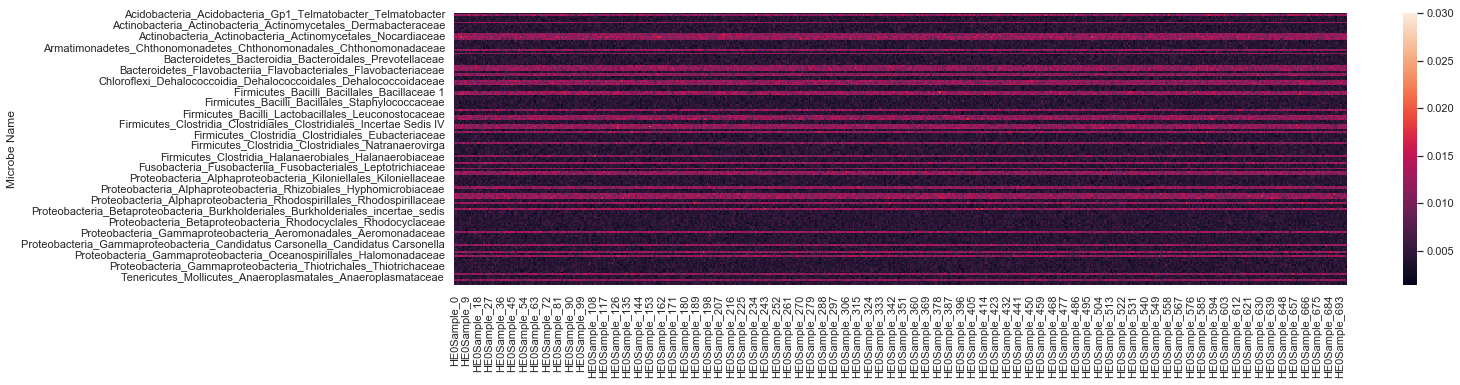

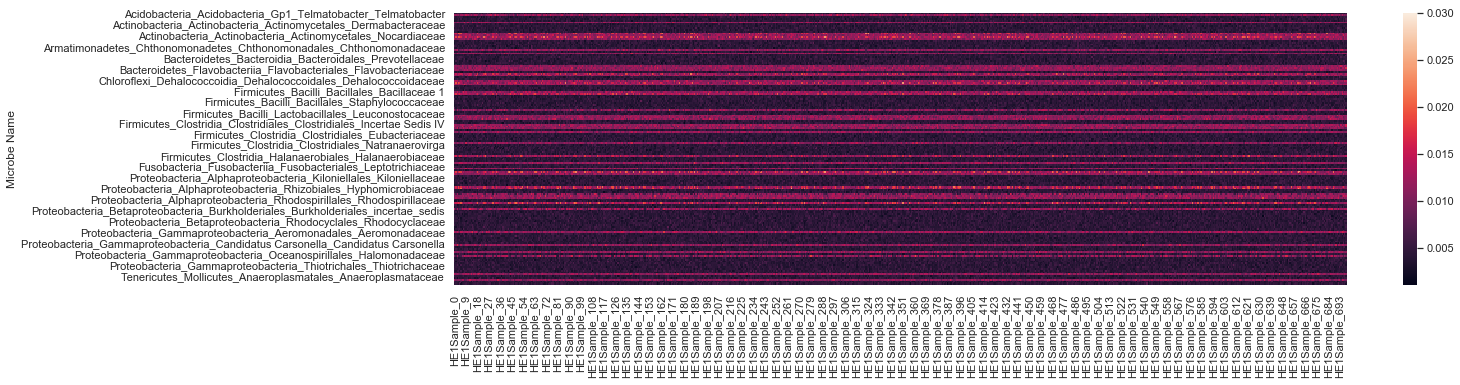

In [13]:
he0_df_heatmap = he0_df.set_index('Microbe Name')
plt.figure(figsize = (20,5))
ax = sns.heatmap(he0_df_heatmap, vmax=0.03)
plt.savefig('heatmap_he0.png', bbox_inches='tight')

he1_df_heatmap = he1_df.set_index('Microbe Name')
plt.figure(figsize = (20,5))
ax = sns.heatmap(he1_df_heatmap, vmax=0.03)
plt.savefig('heatmap_he1.png', bbox_inches='tight')

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [82]:
ctr = 0
alpha = 0.05
for i in range(len(he0_df)):
    _, p_value = sp.stats.ks_2samp(he0_df.iloc[i,1:].values, he1_df.iloc[i,1:].values)
    #print("P-Value for bacteria {0} is {1}".format(he0_df.iloc[i][0], p_value))
    if p_value <= alpha:
        ctr += 1
        print("Bacteria {0} has altered abundance level".format(he0_df.iloc[i][0]))
        
print("Number of bacteria with altered proportions are", ctr)

Bacteria Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3 has altered abundance level
Bacteria Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae has altered abundance level
Bacteria Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae has altered abundance level
Bacteria Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae has altered abundance level
Bacteria Actinobacteria_Actinobacteria_Actinomycetales_Pseudonocardiaceae has altered abundance level
Bacteria Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis has altered abundance level
Bacteria Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae has altered abundance level
Bacteria Candidatus Saccharibacteria_Saccharibacteria_genera_incertae_sedis_Saccharibacteria_genera_incertae_sedis_Saccharibacteria_genera_incertae_sedis has altered abundance level
Bacteria Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae has altered abundance level
Bacteria Firmicutes_Bac

### b. Null Hypothesis of the KS Test in our Context

Null Hypothesis: Ho: Both bacteria samples are drawn from the same sample (i.e. no significant variance between them)

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [15]:
all_alphas = [0.1, 0.05, 0.01, 0.005, 0.001]
ctr = np.zeros(len(all_alphas))
j = 0
p_value_observed = []

for alpha in all_alphas:
    for i in range(len(he0_df)):
        d , p_value = sp.stats.ks_2samp(he0_df.iloc[i,1:].values, he1_df.iloc[i,1:].values)
        if alpha == 0.05:
            p_value_observed.append(p_value)
        if p_value < alpha:
            ctr[j] += 1
    j +=1 

print("Number of bacteria with altered proportions are", ctr)

Number of bacteria with altered proportions are [50. 37. 27. 26. 21.]


## 2. Multiple Testing

### a. P-value

### b. P-value Distribution

### c. Expected Number of Significant p-values

### d. Q-Q plot of p-values

#### i. 

In [16]:
p_values_expected = np.random.uniform(0,1, (149,))

#### ii. 

In [17]:
p_log_obs = -np.log10(p_value_observed)
p_log_exp = -np.log10(p_values_expected)

#### iii. 

In [18]:
p_log_exp.sort()
p_log_obs.sort()

#### iv. 

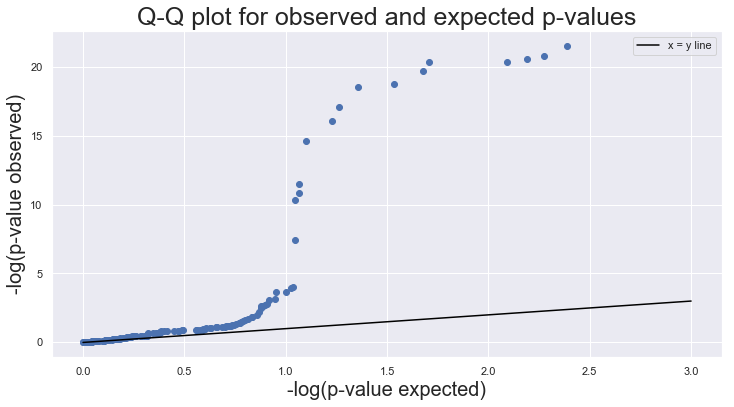

In [19]:
plt.figure(figsize=(12,6))
plt.scatter(p_log_exp, p_log_obs)
plt.show
plt.xlabel('-log(p-value expected)', size=20)
plt.ylabel('-log(p-value observed)', size=20)
plt.title('Q-Q plot for observed and expected p-values', size=25)
plt.plot([0,3],[0,3], label = 'x = y line', color = 'black')
plt.legend()

#### v. 

#### vi. 

### e. Follow-up Questions

#### i. 

#### ii. 

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

In [20]:
pca_he0 = PCA(svd_solver='full')
pca_he1 = PCA(svd_solver='full')
pca_he0_30 = PCA(n_components = 0.3, svd_solver='full')
pca_he1_30 = PCA(n_components = 0.3, svd_solver='full')

pca_he0.fit(he0_df.set_index("Microbe Name").transpose())
pca_he1.fit(he1_df.set_index("Microbe Name").transpose())

pca_he0_30.fit(he0_df.set_index("Microbe Name").transpose())
pca_he1_30.fit(he1_df.set_index("Microbe Name").transpose())

print("Verify if the PCA analysis has been done using microbes as the features:")
print("Total number of PCA components for HE0 are:", len(pca_he0.components_[0]))
print("Total number of features in training data set: ", pca_he0.n_features_)

print("\nTotal number of PCA components for HE1 are:", len(pca_he1.components_[0]))
print("Total number of features in training data set: ", pca_he1.n_features_)

Verify if the PCA analysis has been done using microbes as the features:
Total number of PCA components for HE0 are: 149
Total number of features in training data set:  149

Total number of PCA components for HE1 are: 149
Total number of features in training data set:  149



### b. Ordering Components

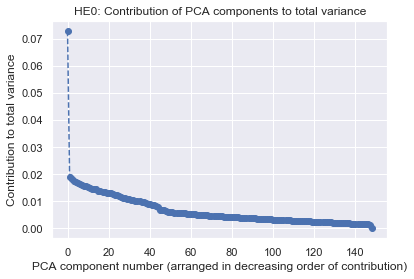

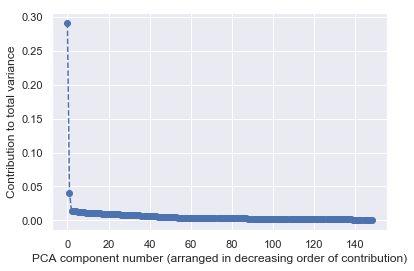

HE0: Contributions of the PCA components that explain atleast 30 percent of the total variance 
 [0.07298918 0.01895261 0.018342   0.01766061 0.01727581 0.01662543
 0.01634677 0.01592039 0.01572604 0.01546221 0.01518119 0.0148396
 0.01462119 0.01437372 0.01437201 0.0139215 ]

HE0: Sum of the above variance contributions is:  0.3126102626688296

HE0: Number of PCA componenets needed to explain 30 percent of the total variance is:  16

HE1: Contributions of the PCA components that explain atleast 30 percent of the total variance 
 [0.29154718 0.04100209]

HE1: Sum of the above variance contributions is:  0.3325492765764465

HE1: Number of PCA componenets needed to explain 30 percent of the total variance is:  2


In [21]:
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.tick_params(axis='both', which='major', labelsize=20)
plt.title("HE0: Contribution of PCA components to total variance")

plt.plot(pca_he0.explained_variance_ratio_, '--o')
plt.xlabel("PCA component number (arranged in decreasing order of contribution)")
plt.ylabel("Contribution to total variance")
plt.show()

plt.plot(pca_he1.explained_variance_ratio_, '--o')
plt.xlabel("PCA component number (arranged in decreasing order of contribution)")
plt.ylabel("Contribution to total variance")
plt.show()

print("HE0: Contributions of the PCA components that explain atleast 30 percent of the total variance \n", pca_he0_30.explained_variance_ratio_)
print("\nHE0: Sum of the above variance contributions is: ", np.sum(pca_he0_30.explained_variance_ratio_))
print("\nHE0: Number of PCA componenets needed to explain 30 percent of the total variance is: ",pca_he0_30.n_components_)

print("\nHE1: Contributions of the PCA components that explain atleast 30 percent of the total variance \n", pca_he1_30.explained_variance_ratio_)
print("\nHE1: Sum of the above variance contributions is: ", np.sum(pca_he1_30.explained_variance_ratio_))
print("\nHE1: Number of PCA componenets needed to explain 30 percent of the total variance is: ", pca_he1_30.n_components_)

(16, 149)
(2, 149)


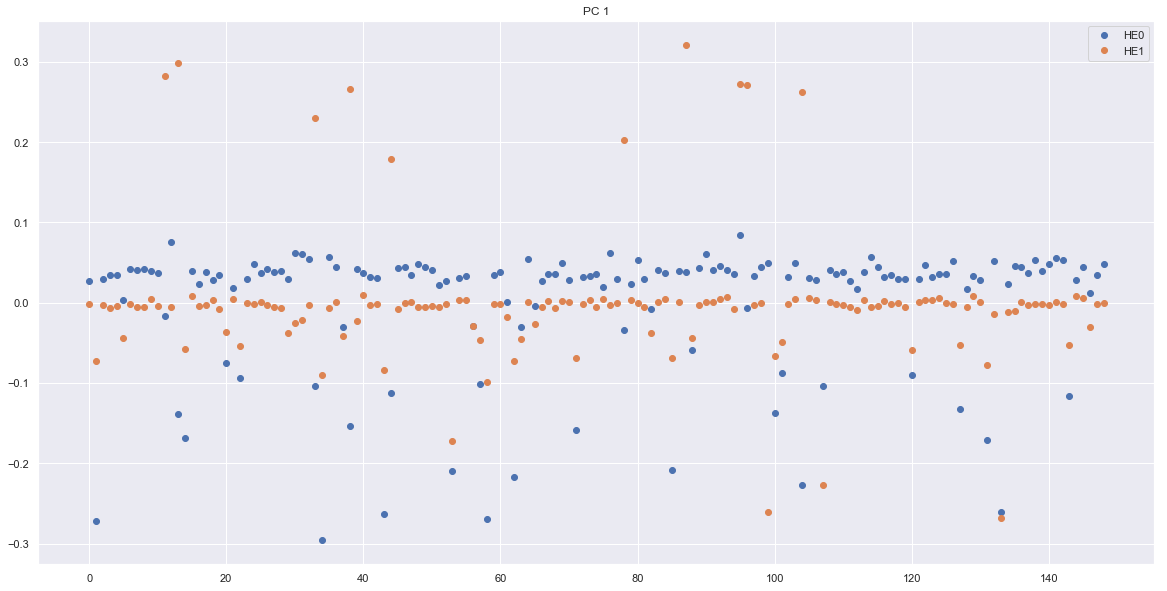

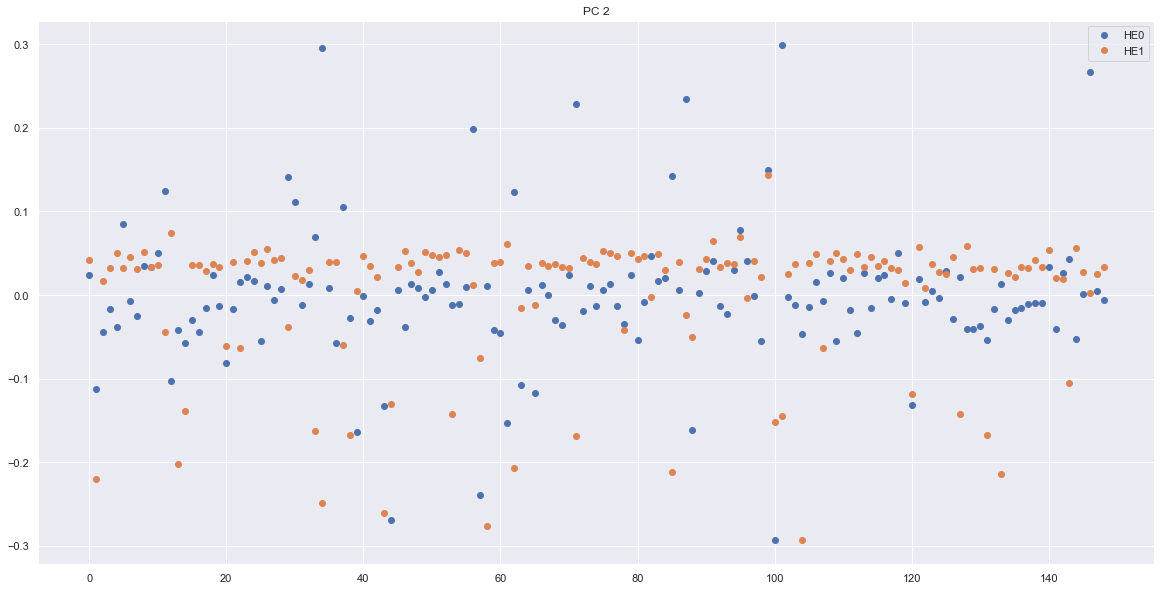

In [78]:
print(pca_he0_30.components_.shape)
print(pca_he1_30.components_.shape)

plt.subplots(figsize=(20,10))
plt.plot(pca_he0_30.components_[0],'o',label='HE0')
plt.title("PC 1")
plt.plot(pca_he1_30.components_[0],'o',label='HE1')
plt.legend()
plt.show()

plt.subplots(figsize=(20,10))
plt.plot(pca_he0_30.components_[1],'o',label='HE0')
plt.title("PC 2")
plt.plot(pca_he1_30.components_[1],'o',label='HE1')
plt.legend()
plt.show()

### c. Scatter Plot of Microbe Abundance

HE0: Check if the dimensionality has reduced after PCA analysis.
Number of features are: 2


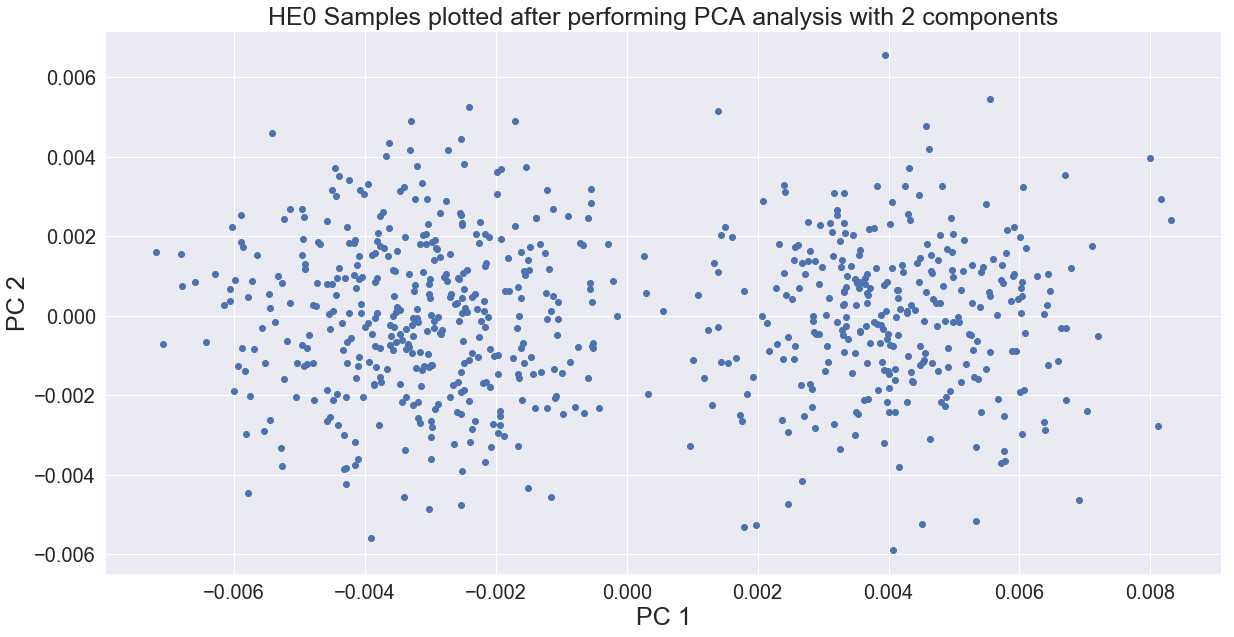


HE1: Check if the dimensionality has reduced after PCA analysis.
Number of features are: 2


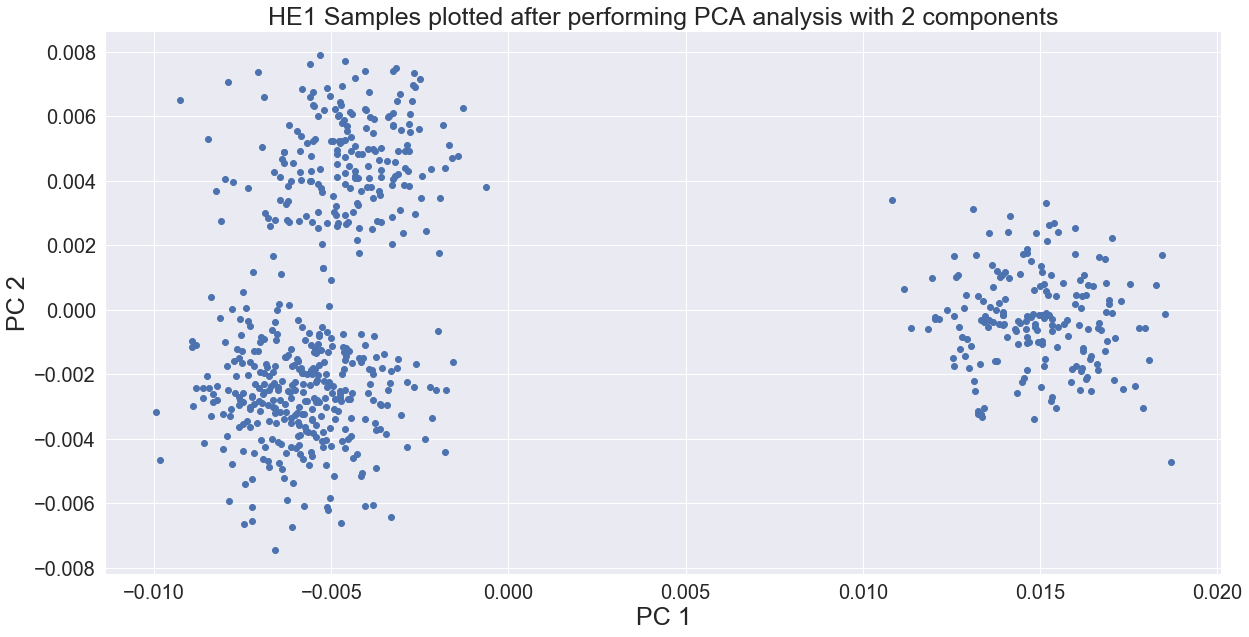

In [51]:
pca_he0_2comp = PCA (n_components = 2, svd_solver='auto')
dummy = pca_he0_2comp.fit_transform(he0_df.set_index("Microbe Name").transpose())
print("HE0: Check if the dimensionality has reduced after PCA analysis.")
print("Number of features are:", pca_he0_2comp.n_components)
he0_post_pca = dummy.T

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(he0_post_pca[0], he0_post_pca[1],'o')
plt.title("HE0 Samples plotted after performing PCA analysis with 2 components", size=25)
plt.xlabel("PC 1", size=25)
plt.ylabel("PC 2", size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

dummy = pca_he1_30.transform(he1_df.set_index("Microbe Name").transpose())
he1_post_pca = dummy.T
print("\nHE1: Check if the dimensionality has reduced after PCA analysis.")
print("Number of features are:", pca_he1_30.n_components_)

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(he1_post_pca[0],he1_post_pca[1],'o')
plt.title("HE1 Samples plotted after performing PCA analysis with 2 components", size=25)
plt.xlabel("PC 1", size=25)
plt.ylabel("PC 2", size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()


HE1: Check if the dimensionality has reduced after PCA analysis.
Number of features are: 2


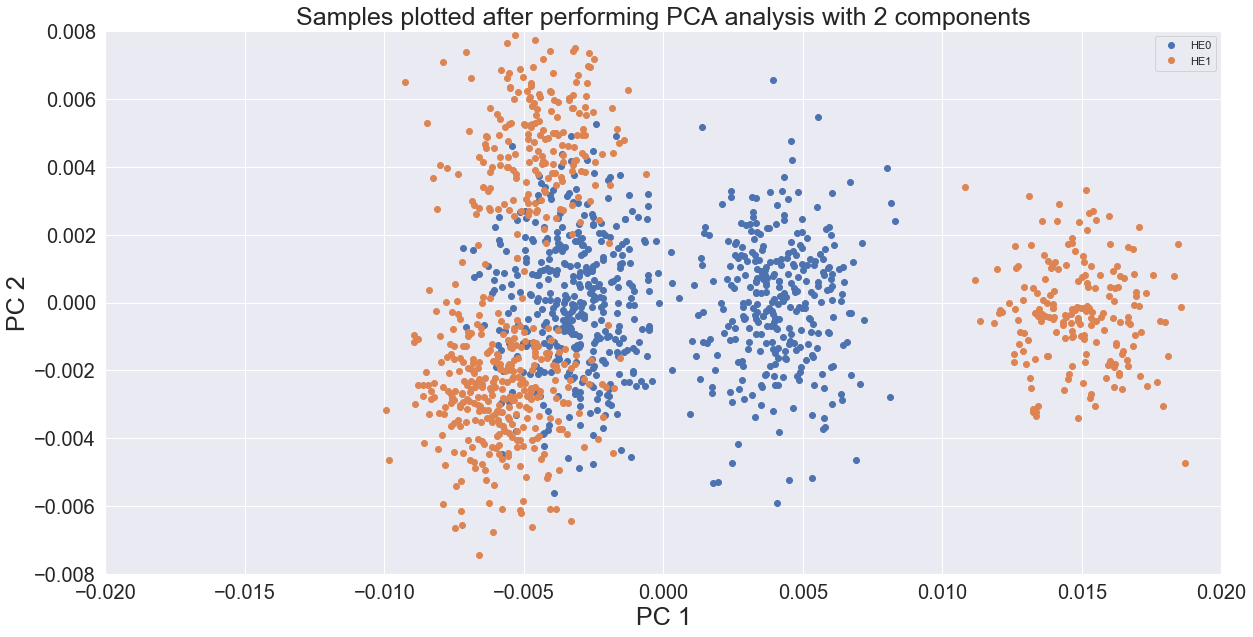

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.tick_params(axis='both', which='major', labelsize=20)

plt.plot(he0_post_pca[0], he0_post_pca[1],'o', label='HE0')
#plt.title("HE0 Samples plotted after performing PCA analysis with 2 components", size=25)
plt.xlabel("PC 1", size=25)
plt.ylabel("PC 2", size=25)

plt.ylim([-0.008,0.008])
plt.xlim([-0.02,0.02])

dummy = pca_he1_30.transform(he1_df.set_index("Microbe Name").transpose())
he1_post_pca = dummy.T
print("\nHE1: Check if the dimensionality has reduced after PCA analysis.")
print("Number of features are:", pca_he1_30.n_components_)

plt.plot(he1_post_pca[0],he1_post_pca[1],'o', label='HE1')
plt.title("Samples plotted after performing PCA analysis with 2 components", size=25)
plt.xlabel("PC 1", size=25)
plt.ylabel("PC 2", size=25)
plt.legend()
plt.show()

## 2. t-SNE

### a. Performing t-SNE

Check shape of new embedded data (699, 2)


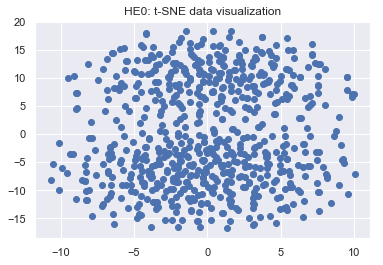

In [23]:
he0_embedded = TSNE(n_components=2, random_state = 42).fit_transform(he0_df.set_index("Microbe Name").transpose())
print("Check shape of new embedded data", he0_embedded.shape)
plt.plot(he0_embedded.T[0],he0_embedded.T[1], 'o')
plt.title("HE0: t-SNE data visualization")
plt.show()

Check shape of new embedded data (699, 2)


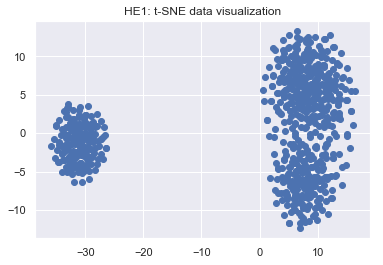

In [24]:
he1_embedded = TSNE(n_components=2, random_state = 42).fit_transform(he1_df.set_index("Microbe Name").transpose())
print("Check shape of new embedded data", he1_embedded.shape)
plt.plot(he1_embedded.T[0],he1_embedded.T[1], 'o')
plt.title("HE1: t-SNE data visualization")
plt.show()

### b. Comparing with PCA

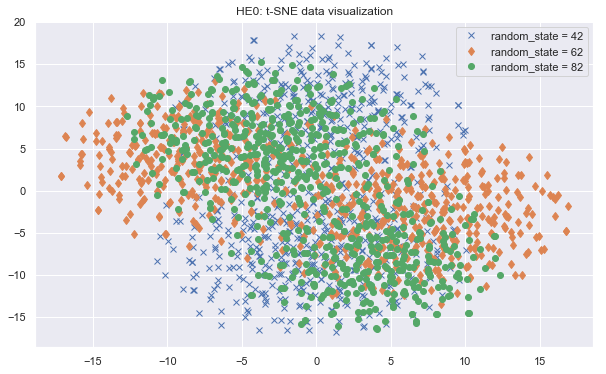

In [25]:
plt.figure(figsize=(10,6))
he0_embedded = TSNE(n_components=2, random_state = 42).fit_transform(he0_df.set_index("Microbe Name").transpose())
plt.plot(he0_embedded.T[0],he0_embedded.T[1], 'x', label='random_state = 42')

he0_embedded = TSNE(n_components=2, random_state = 62).fit_transform(he0_df.set_index("Microbe Name").transpose())
plt.plot(he0_embedded.T[0],he0_embedded.T[1], 'd', label='random_state = 62')

he0_embedded = TSNE(n_components=2, random_state = 82).fit_transform(he0_df.set_index("Microbe Name").transpose())
plt.plot(he0_embedded.T[0],he0_embedded.T[1], 'o', label='random_state = 82')
plt.title("HE0: t-SNE data visualization")
plt.legend()
plt.show()

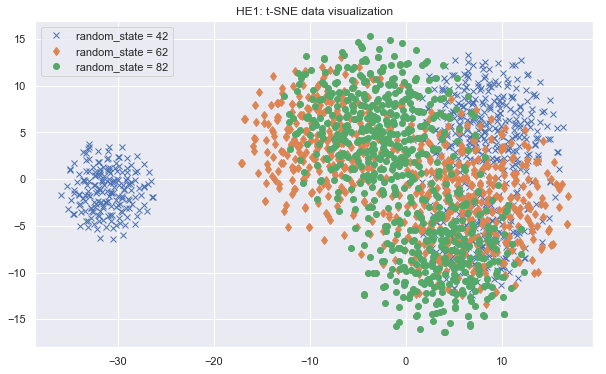

In [26]:
plt.figure(figsize=(10,6))
he1_embedded = TSNE(n_components=2, random_state = 42).fit_transform(he1_df.set_index("Microbe Name").transpose())
plt.plot(he1_embedded.T[0],he1_embedded.T[1], 'x', label='random_state = 42')

he1_embedded = TSNE(n_components=2, random_state = 62).fit_transform(he0_df.set_index("Microbe Name").transpose())
plt.plot(he1_embedded.T[0],he1_embedded.T[1], 'd', label='random_state = 62')

he1_embedded = TSNE(n_components=2, random_state = 82).fit_transform(he0_df.set_index("Microbe Name").transpose())
plt.plot(he1_embedded.T[0],he1_embedded.T[1], 'o', label='random_state = 82')
plt.title("HE1: t-SNE data visualization")
plt.legend()
plt.show()

## 3. Clustering

### a. K-Means

Shape of kmeans_he0 (699,)
Shape of kmeans_he0 (699,)


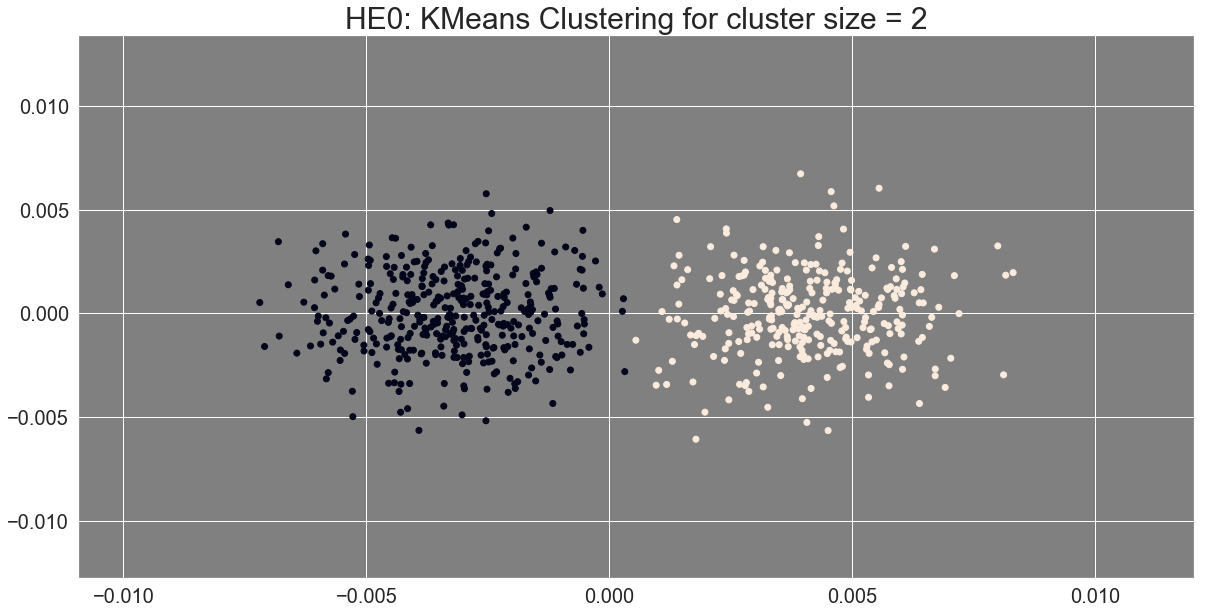

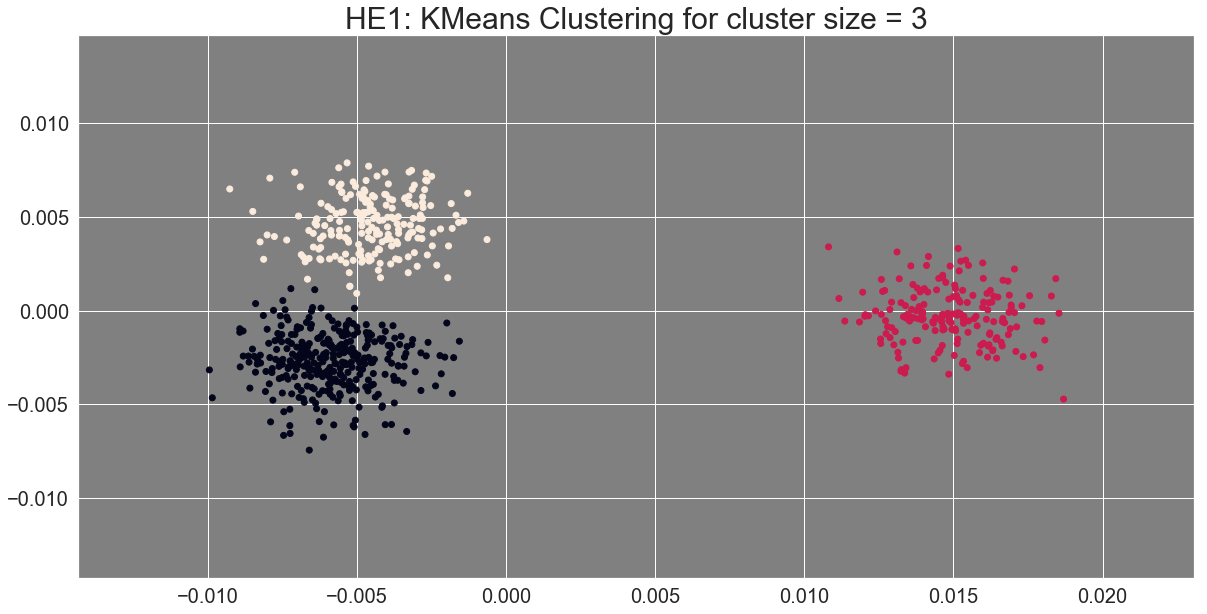

In [27]:
kmeans_he0 = KMeans(n_clusters=2).fit_predict(he0_post_pca.T)
kmeans_he1 = KMeans(n_clusters=3).fit_predict(he1_post_pca.T)
print("Shape of kmeans_he0", kmeans_he0.shape)
print("Shape of kmeans_he0", kmeans_he0.shape)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he0_post_pca[0], he0_post_pca[1] ,  c = kmeans_he0)
plt.title("HE0: KMeans Clustering for cluster size = 2", size=30)
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he1_post_pca[0], he1_post_pca[1] ,  c = kmeans_he1)
plt.title("HE1: KMeans Clustering for cluster size = 3", size=30)
plt.show()

### b. GMM

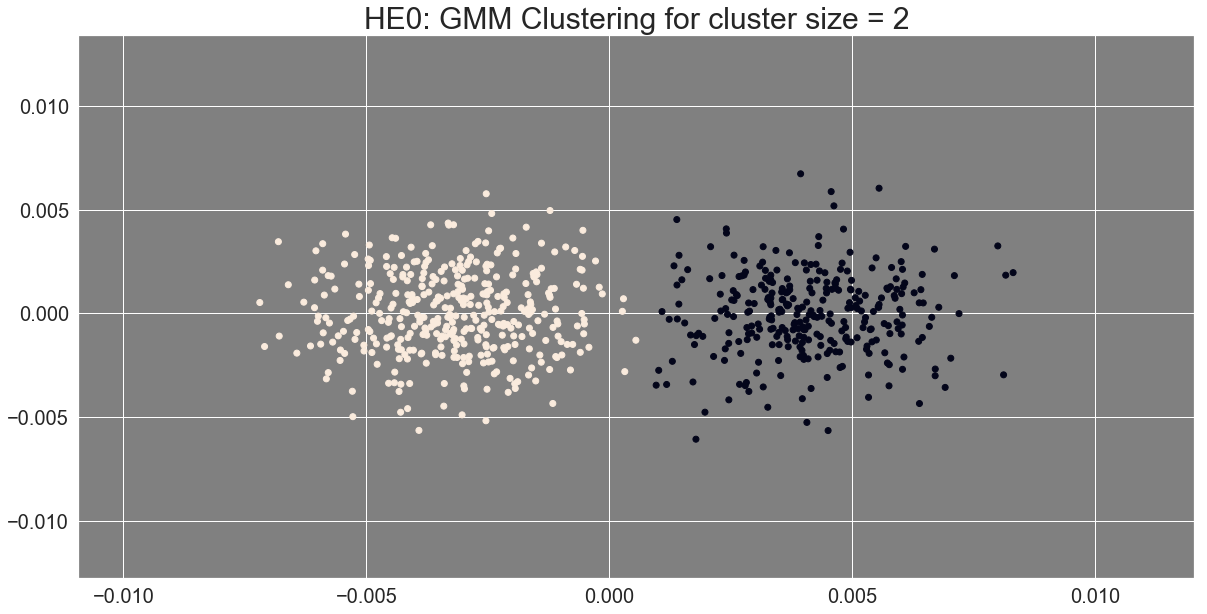

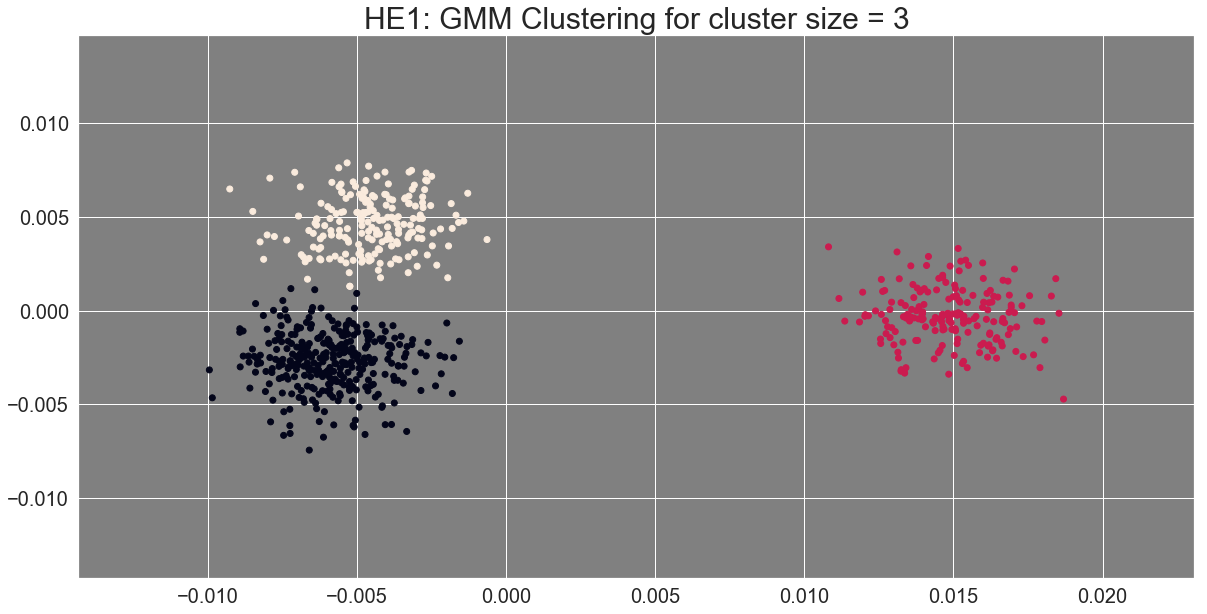

In [28]:
gmm_he0 = GaussianMixture(n_components=2, init_params = 'kmeans').fit_predict(he0_post_pca.T)
gmm_he1 = GaussianMixture(n_components=3, init_params = 'kmeans').fit_predict(he1_post_pca.T)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he0_post_pca[0], he0_post_pca[1] , c = gmm_he0)
plt.title("HE0: GMM Clustering for cluster size = 2", size=30)
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he1_post_pca[0], he1_post_pca[1] , c = gmm_he1)
plt.title("HE1: GMM Clustering for cluster size = 3", size=30)
plt.show()

### c. Single and Complete Linkage Hierarchical

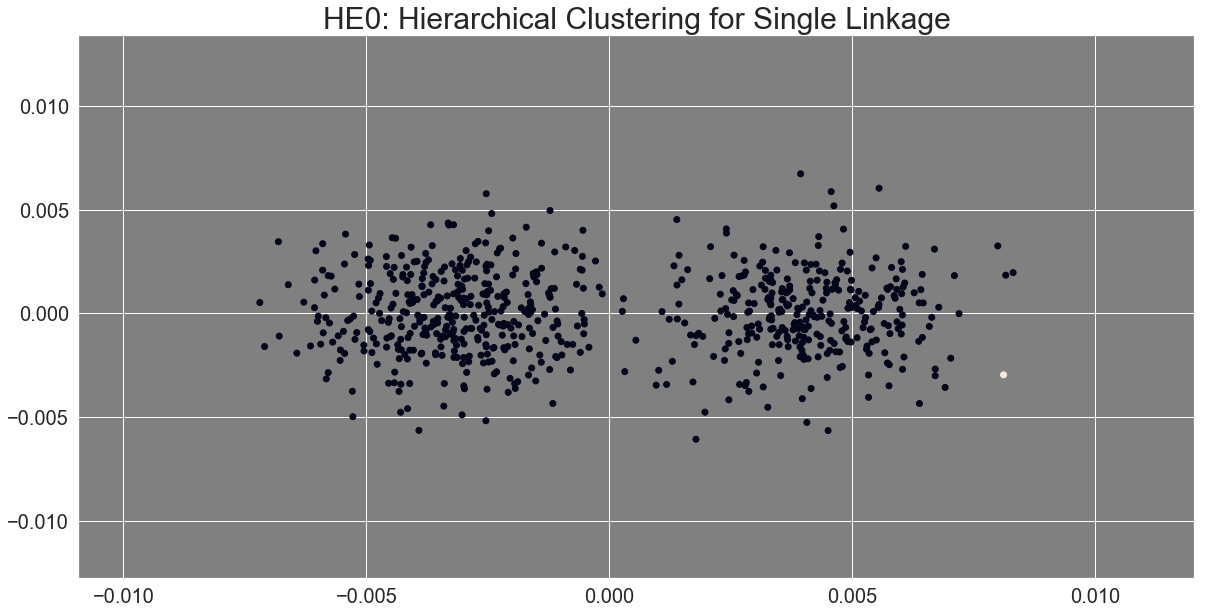

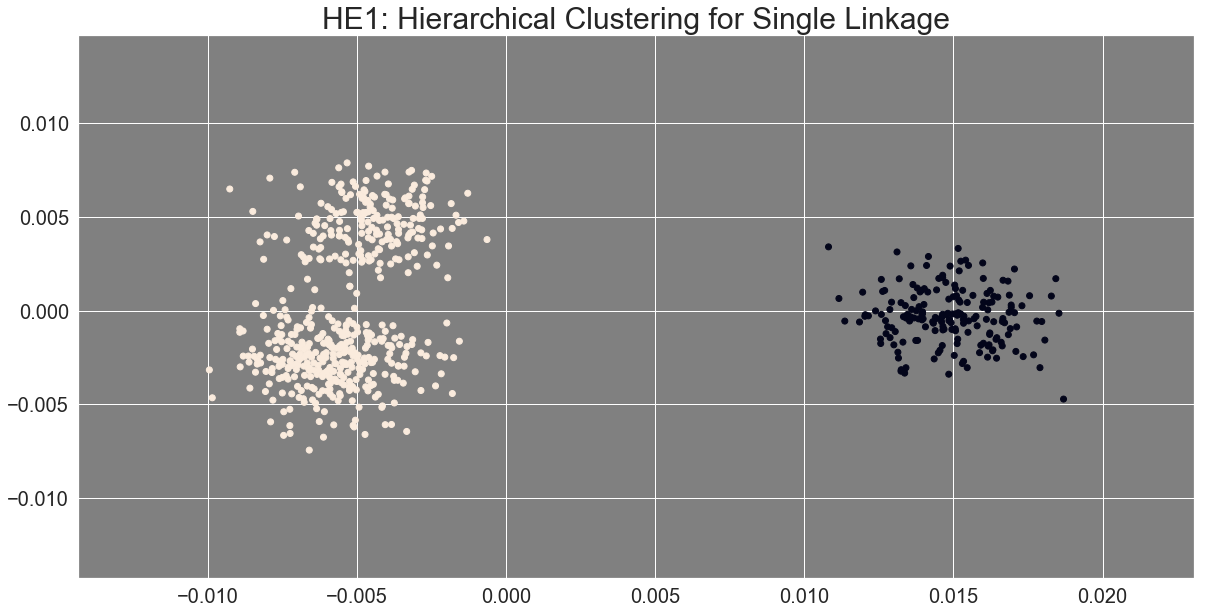

In [29]:
#Single Link
ac_single_he0 = ac(linkage = 'single').fit_predict(he0_post_pca.T)
ac_single_he1 = ac(linkage = 'single').fit_predict(he1_post_pca.T)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he0_post_pca[0], he0_post_pca[1] , c = ac_single_he0)
plt.title("HE0: Hierarchical Clustering for Single Linkage", size=30)
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he1_post_pca[0], he1_post_pca[1] , c = ac_single_he1)
plt.title("HE1: Hierarchical Clustering for Single Linkage", size=30)
plt.show()

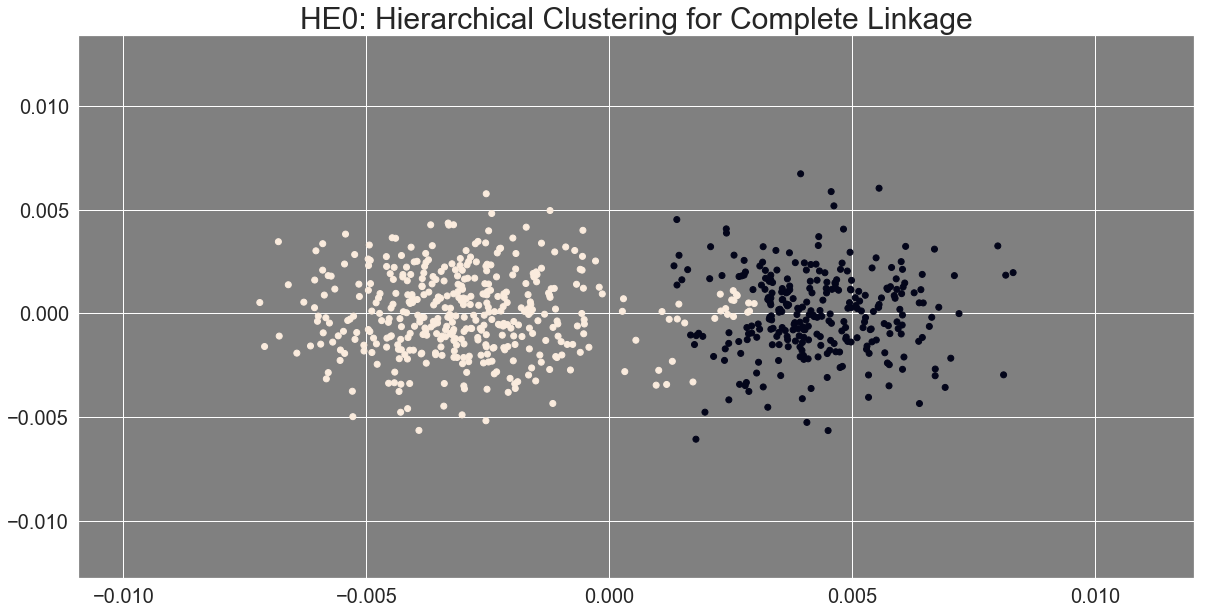

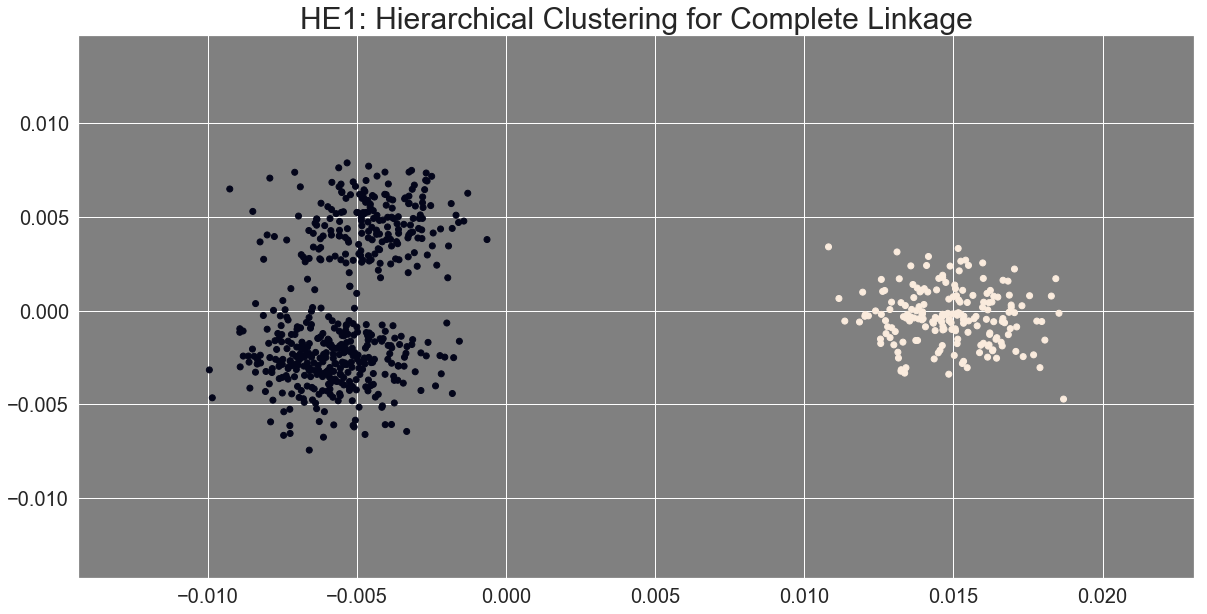

In [47]:
#Complete Link Link
ac_comp_he0 = ac(linkage = 'complete').fit_predict(he0_post_pca.T)
ac_comp_he1 = ac(linkage = 'complete').fit_predict(he1_post_pca.T)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he0_post_pca[0], he0_post_pca[1] , c = ac_comp_he0)
plt.title("HE0: Hierarchical Clustering for Complete Linkage", size=30)
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.scatter(he1_post_pca[0], he1_post_pca[1] , c = ac_comp_he1)
plt.title("HE1: Hierarchical Clustering for Complete Linkage", size=30)
plt.show()

### d. Single vs Complete Link Hierarchical Clustering

Single Link clustering is sensitive to outliers, whereas Complete Link is robust to outliers.

Single Link:

HE0: There are two clusters, but one cluster has only one data point. The reason for this weird clustering is that the data for HE0 has many outliers. Single link is not well equipped to handle such datasets.

HE1: There are two well defined clusters because there are no outliers (in each cluster)

Complete Link:

HE0: There are two well defined clusters. Complete link is robust to outliers and hence, it could cluster the dataset.

HE1: There are two well defined clusters. There are not too many outliers, so complete clustering works well.

### e. Comparing Clustering Techniques

Clustering Techniques:
    
(1) HE0: 2 clusters for all techniques
- KMeans: Well defined clusters
- GMM: Well defined clusters
- Single Link: Not very well defined clusters
- Complete Link: Better than single link but still not the best defined clusters. Some points in right cluster are being assigned to the left cluster

(2) HE1: 3 clusters for KMeans and GMM; 2 clusters for hierarchical clustering techniques
- KMeans: Well defined 3 clusters
- GMM: Well defined 3 clusters
- Single Link: Well defined clusters (but two instead of three)
- Complete Link: Well defined clusters (but two instead of three)

### f. What do Clusters Represent

### g. Deciding on Number of Clusters

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

### c. Identify Microbes with Significantly Altered Relative Abundance

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

(149,)
Level of bacteria Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae has increased significantly
Level of bacteria Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae has increased significantly
Level of bacteria Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae has increased significantly
Level of bacteria Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae has increased significantly
Level of bacteria Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI has increased significantly
Level of bacteria Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae has increased significantly
Level of bacteria Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum has increased significantly
Level of bacteria Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae has increased significantly
Level of bacteria Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiaceae has increased signific

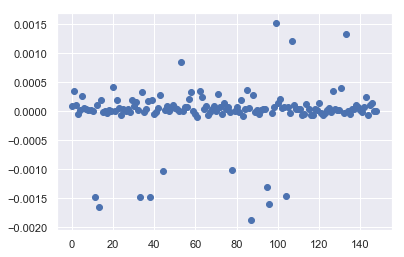

In [105]:
a = he0_df.iloc[:,1:].apply(np.mean, axis=1) 
b = he1_df.iloc[:,1:].apply(np.mean, axis=1)
print(a.shape)

for i in range(len(he0_df)):
    if (b[i] - a[i]) > 0.0005:
        print("Level of bacteria {0} has increased significantly".format(he0_df.iloc[i][0]))
        
print('\n')

for i in range(len(he0_df)):
    if (a[i] - b[i]) > 0.0005:
        print("Level of bacteria {0} has decreased significantly".format(he0_df.iloc[i][0]))

plt.plot(a-b,'o')
plt.show()


### b. Biological Relations